In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd

In [2]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Load model

### User Input:
1. model_path - path to .pickle file of pretrained model
2. train_data_path - path to train data
3. test_data_path - path to test data
4. categorical_features - which features are categorical

In [3]:
model_path = 'loan_model.pickle'
train_data_path = 'loan_model_train_data.csv'
test_data_path = 'loan_model_test_data.csv'
categorical_features = [0, 1, 2, 3, 4, 9, 10, 11]

---

In [4]:
import pickle
pickle_in = open(model_path,"rb")
model = pickle.load(pickle_in)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [5]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [6]:
def model_prediction(x):
    return model.predict_proba(x)

# Skater (analyze model)

## Feature importance

[12/12] features ████████████████████ Time elapsed: 0 seconds

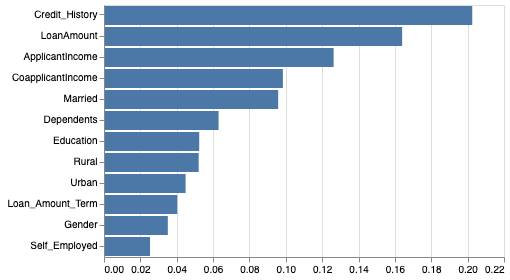

In [7]:
from src import feature_importance
features = feature_importance.analyze(model_prediction, train_data)
chart = feature_importance.render_feature_importance(features)
chart

## partial dependence 


In [79]:
# partial_dependence = interpreter.partial_dependence.partial_dependence(['LoanAmount'], skater_model, grid_resolution=30)
from src import partial_dependence
dependency = partial_dependence.get_dependency(model_prediction, train_data, ['LoanAmount'])
alt.Chart(dependency).mark_line().encode(
    x='LoanAmount',
    y='predicted_1'
)

[29/29] grid cells ████████████████████ Time elapsed: 0 seconds

ValueError: Dataframe contains invalid column name: 1. Column names must be strings

Chart({
  data:     LoanAmount       1        sd
  0    57.500000  0.7748  0.253624
  1    68.491379  0.6867  0.264335
  2    70.646552  0.6931  0.262226
  3    80.594828  0.6809  0.260317
  4    83.543103  0.6994  0.265781
  5    94.422414  0.7238  0.286171
  6   100.000000  0.7374  0.284923
  7   105.008621  0.7567  0.281203
  8   110.000000  0.7650  0.282657
  9   112.000000  0.7628  0.284176
  10  113.000000  0.7628  0.284176
  11  114.000000  0.7628  0.284176
  12  116.000000  0.7706  0.284773
  13  120.025862  0.7730  0.281480
  14  125.974138  0.7586  0.278937
  15  128.000000  0.7713  0.268861
  16  130.000000  0.7721  0.269317
  17  132.818966  0.7376  0.260665
  18  136.000000  0.7287  0.255707
  19  146.293103  0.6894  0.268231
  20  157.663793  0.6561  0.280505
  21  173.836207  0.6517  0.289788
  22  179.120690  0.6757  0.288374
  23  187.508621  0.6727  0.282249
  24  203.198276  0.6728  0.284886
  25  232.293103  0.6869  0.284391
  26  248.474138  0.6359  0.267808
  27  

In [8]:
dependency = partial_dependence.get_dependency(model_prediction, X[1], ['ApplicantIncome'])
alt.Chart(dependency).mark_line().encode(
    x='ApplicantIncome',
    y='predicted_1'
)

[30/30] grid cells ████████████████████ Time elapsed: 0 seconds

ValueError: Dataframe contains invalid column name: 1. Column names must be strings

Chart({
  data:     ApplicantIncome       1        sd
  0       2008.750000  0.7348  0.255165
  1       2145.681034  0.7390  0.255654
  2       2241.689655  0.7177  0.261336
  3       2500.000000  0.7502  0.243187
  4       2635.844828  0.7413  0.249528
  5       2882.387931  0.7380  0.262557
  6       2975.905172  0.7340  0.266015
  7       3089.594828  0.7223  0.264939
  8       3169.017241  0.7182  0.265271
  9       3214.827586  0.7131  0.263436
  10      3294.637931  0.7124  0.263261
  11      3501.810345  0.6763  0.260477
  12      3602.198276  0.7063  0.256652
  13      3719.560345  0.6953  0.247443
  14      3859.206897  0.7149  0.245088
  15      3991.293103  0.7089  0.247529
  16      4180.784483  0.6944  0.251612
  17      4274.405172  0.6987  0.245659
  18      4527.620690  0.6910  0.245884
  19      4635.939655  0.6924  0.242698
  20      5302.715517  0.6967  0.243268
  21      5604.284483  0.6798  0.238688
  22      5770.896552  0.6798  0.240025
  23      6182.293103  0.6

In [4]:
dependency = partial_dependence.get_dependency(model_prediction, 
                                               X[1], 
                                               ['LoanAmount', 'ApplicantIncome'],
                                               resolution=10)

alt.Chart(dependency).mark_rect().encode(
    x='LoanAmount:O',
    y='ApplicantIncome:O',
    color='predicted_1:Q'
)

NameError: name 'partial_dependence' is not defined

### TreeSurrogates (Experimental)

In [13]:
# help(interpreter.tree_surrogate)

## Contrastive explanation
Based on https://arxiv.org/pdf/1806.07470.pdf and https://github.com/MarcelRobeer/ContrastiveExplanation

In [8]:
# from IPython.core.debugger import set_trace
import src.contrastive_explanation as ce
dm = ce.domain_mappers.DomainMapperTabular(train_data.values, 
                                           feature_names = train_data.columns,
                                           categorical_features = categorical_features)

exp = ce.ContrastiveExplanation(dm)

### User Input:

- select test data indexes

In [9]:
indexes = [3,6]

---

In [10]:
for i in indexes:
    sample = test_data.values[i]
    print('------')
    print(sample)
    print(exp.explain_instance_domain(model_prediction, sample))

------
[0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+03 1.666e+03
 1.000e+02 4.800e+02 0.000e+00 1.000e+00 0.000e+00]
The model predicted '0' instead of '1' because 'LoanAmount <= 235.988'
------
[0.000e+00 1.000e+00 2.000e+00 0.000e+00 0.000e+00 3.083e+03 2.168e+03
 1.260e+02 3.600e+02 1.000e+00 1.000e+00 0.000e+00]
The model predicted '1' instead of '0' because 'Loan_Amount_Term <= 361.553'
